### exp: eqtl prediction, slope prediction, gpn for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['MLP', 'CNN', 'RNN']
tissue = 'Heart_Left_Ventricle'
data_path = '../../../../../datasets_embedding/gpn/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000236423.5   chr1_3900688_T_C_b38           316  0.084098   
1   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.134969   
2   ENSG00000228172.5  chr1_25820023_G_C_b38          -738  0.463303   
3  ENSG00000117640.17  chr1_25820023_G_C_b38          -775  0.463303   
4  ENSG00000000938.12  chr1_27634281_G_A_b38          -996  0.067278   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0         52       55  1.657173e-06  0.342601  0.069935   
1         82       88  6.482217e-12  0.276024  0.038419   
2        242      303  4.628220e-23  0.513832  0.047313   
3        242      303  9.349158e-65  0.530491  0.023360   
4         42       44  2.717342e-12  0.523637  0.071486   

                                          seq_before  \
0  AGGAGAGCCTCCATGCAGCTCAGAGCCTCCCAAGTGGACCGGGACC...   
1  agcccagatcccgccactgcactccagcctgggcgacacagcaaga...   
2  CCCGCGGGGGCACGGTCTCGATGGAGGGGAGTGTGCTCCGC

##### model 1: mlp

rmse= 1.22254479859887
r2= -0.586646168504283
pcc= 0.052515157310457646
pcc_p= 0.8031251416541358


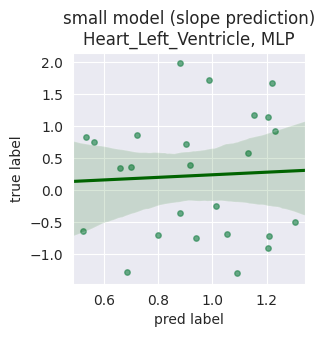

In [4]:
# model 1: mlp
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

2024-11-06 21:40:18.712872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 21:40:18.725775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 21:40:18.729463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 21:40:18.739606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 21:40:19.471332: W tensorflow/comp

rmse= 0.9879655212403983
r2= -0.03617736218355039
pcc= -0.11162580109531667
pcc_p= 0.5952663725215667


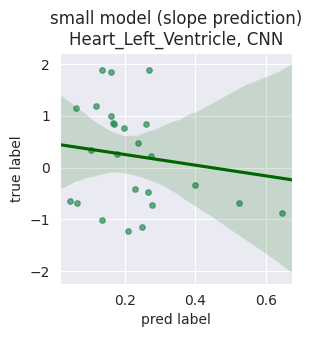

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

rmse= 1.1850689143523003
r2= -0.490862995475549
pcc= -0.3869421581451167
pcc_p= 0.05602304435998116


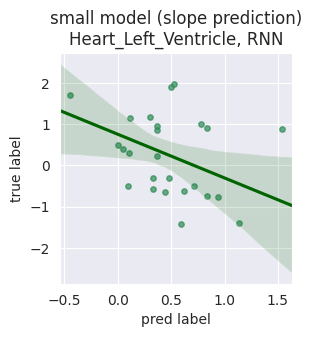

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [7]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3891607_T_C_b38         -8678  0.237003   
1   ENSG00000158292.6   chr1_6262459_G_C_b38          1484  0.097859   
2  ENSG00000117122.13  chr1_16988930_G_A_b38          8095  0.422018   
3  ENSG00000183431.11  chr1_37997832_C_T_b38          6911  0.397554   
4  ENSG00000162604.12  chr1_61723869_T_C_b38         -1554  0.226300   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        134      155  1.254417e-46  0.807717  0.046026   
1         61       64  4.483494e-43  1.232429  0.074424   
2        216      276  4.477894e-16  0.309680  0.035791   
3        201      260  8.121680e-28  0.426557  0.034783   
4        131      148  3.871276e-08  0.233419  0.041253   

                                          seq_before  \
0  AACAAAAGAAATTAACAGCAAGCGCGGGGTGGATGTTCAAAAAAAC...   
1  TATCCAGACAGGACCTCGGTCTGCAGGAGCCCCCAGGGCAGCTTGC...   
2  GCTGATGGCCCAGCCAGCCCAGGGCCCATAACCCCCTCCCC

##### model 1: mlp

rmse= 0.7720097698192693
r2= -0.20200359272065738
pcc= 0.3520994612556511
pcc_p= 0.07772312127059627


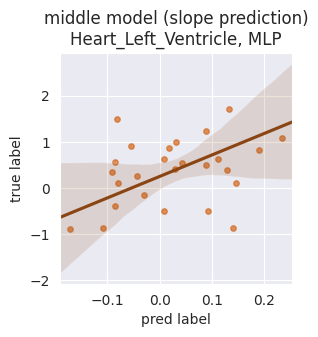

In [8]:
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

rmse= 0.92376467676279
r2= -0.7210079480854199
pcc= 0.12709382532710922
pcc_p= 0.5361146516517006


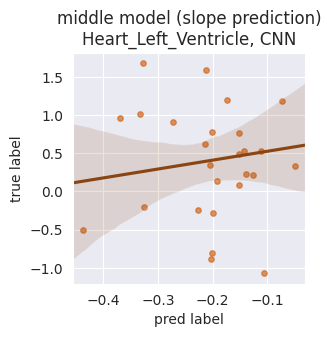

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

rmse= 0.9296527910149482
r2= -0.7430174215576879
pcc= 0.20957991281879784
pcc_p= 0.3041553149832157


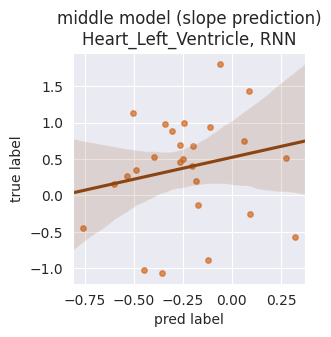

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [11]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3913050_A_G_b38         12765  0.238532   
1  ENSG00000219481.10  chr1_16577626_T_G_b38        -35936  0.470948   
2  ENSG00000058453.16  chr1_16907772_T_A_b38        -14178  0.223242   
3   ENSG00000204219.9  chr1_23383982_C_T_b38        -40758  0.478593   
4  ENSG00000186501.14  chr1_27335461_C_T_b38         13316  0.012232   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        135      156  1.310923e-45  0.803954  0.046565   
1        249      308  6.291642e-12  0.370057  0.051472   
2        136      146  1.943628e-24  0.406539  0.036065   
3        229      313  2.416720e-17  0.215370  0.023740   
4          8        8  1.017953e-14  1.098259  0.134080   

                                          seq_before  \
0  ggaagcagtatgtgggatgtgaactgaagtgcacctggaaatcctc...   
1  tatgcgctagggcacctgggggccggcagagccgttcccctacGca...   
2  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

##### model 1: mlp

rmse= 0.8500105719541021
r2= -0.0265405947822841
pcc= -0.0346607377286026
pcc_p= 0.8232541452295582


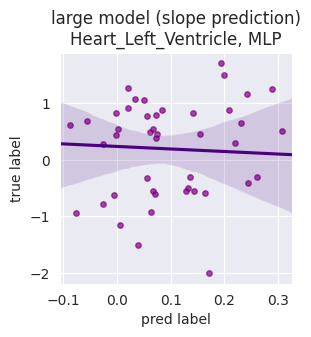

In [12]:
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

rmse= 0.8493905659555588
r2= -0.025043603504864898
pcc= 0.04473574149769953
pcc_p= 0.7730827031564524


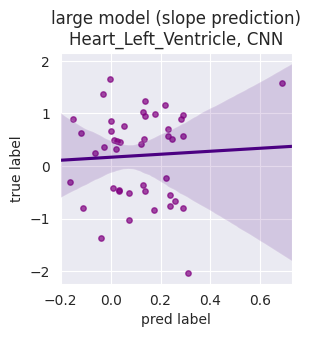

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

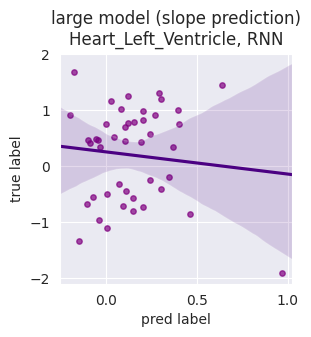

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()